# **ASSIGNMENT 3**

**Task**: forecast the real price of gasoline for the US.

**Dataset**: gasoline.xlsx contains two monthly time series. The nominal price of gasoline and the CPI. 


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fredapi import Fred
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

pd.set_option("display.precision", 2)

In [63]:
gasoline = pd.read_excel('gasoline.xls')

# rename the columns
gasoline.rename(columns=
                {'Unnamed: 1': 'CPI',
                 'Unnamed: 2': 'Nominal_Price',
                 'FRED Graph Observations': 'Time'},
                 inplace = True)

# convert to datetime
gasoline['Time'] = pd.to_datetime(gasoline['Time'], errors = 'coerce')

# remove the unnecessary descriptions
gasoline = gasoline.query("Time >= '1990-11-01'")

gasoline.head()

,Time,CPI,Nominal_Price
11,1990-11-01,1.32,133.7
12,1990-12-01,1.34,134.2
13,1991-01-01,1.18,134.7
14,1991-02-01,1.09,134.8
15,1991-03-01,1.04,134.8


# 1) create the real price of gasoline

CPI has value = 100 for 1984: is it meaningful, considering that the observations begin from 1990?

In [87]:
gasoline['Real_Price'] = (gasoline['Nominal_Price']/gasoline['CPI'])*100
gasoline.head(5)

,Time,CPI,Nominal_Price,Real_Price
11,1990-11-01,1.32,133.7,10098.19
12,1990-12-01,1.34,134.2,10007.46
13,1991-01-01,1.18,134.7,11415.25
14,1991-02-01,1.09,134.8,12318.94
15,1991-03-01,1.04,134.8,12961.54


It should be: nominal/cpi_base_year*cpi_present_year

## 2)  Plot real and nominal prices over time.

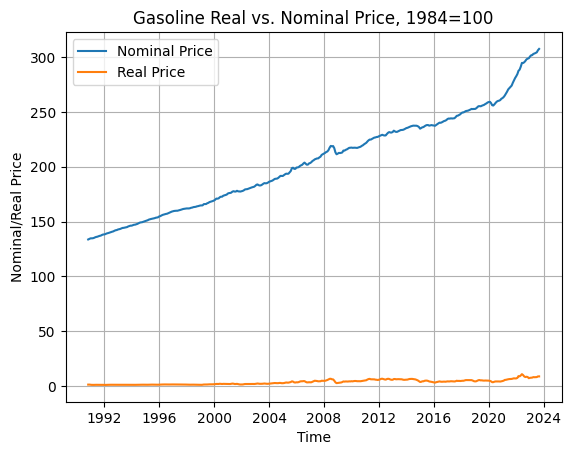

In [86]:
plt.plot(gasoline['Time'], gasoline['Nominal_Price'], label = 'Nominal Price')
plt.plot(gasoline['Time'], gasoline['Real_Price'], label='Real Price')

plt.title('Gasoline Real vs. Nominal Price, 1984=100')
plt.xlabel('Time')
plt.ylabel('Nominal/Real Price')
plt.legend()
plt.grid()

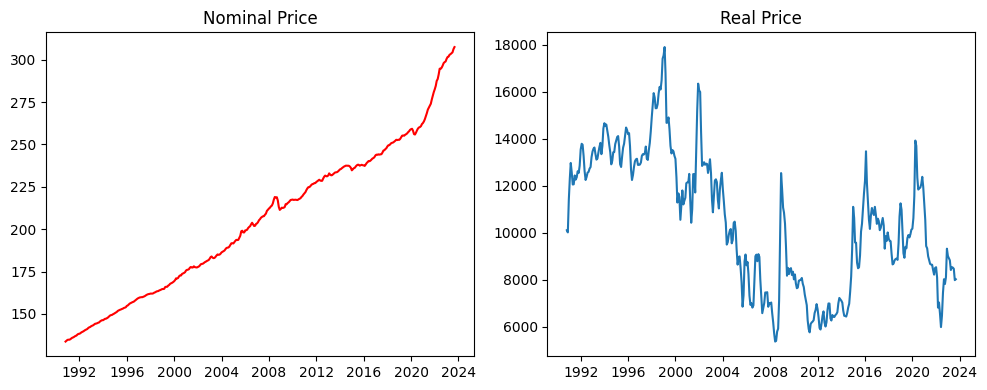

In [96]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
ax[0].plot(gasoline['Time'], gasoline['Nominal_Price'], color='red')
ax[0].set_title('Nominal Price')

ax[1].plot(gasoline['Time'], gasoline['Real_Price'])
ax[1].set_title('Real Price')

plt.tight_layout()
plt.show()

## 3) Consider the sample from obs 1 to Dec 2014. Plot the sample ACF of 
- $y_{t}$ 
- $\Delta{y_t} = y_{t} - y_{t-1}$


In [66]:
# filter the data as requestes
filtered_gasoline = gasoline.query(" Time <= '2014-12-01'")

# convert the data from float to numeric...
filtered_gasoline['Real_Price'] = pd.to_numeric(filtered_gasoline['Real_Price'], errors='coerce')

# ... otherwise we couldn't apply the .log() function
filtered_gasoline['Log_Real_Price'] = np.log(filtered_gasoline['Real_Price'])

# create the column delta for the first difference of the log price
filtered_gasoline['Delta_Log'] = (filtered_gasoline['Log_Real_Price']-filtered_gasoline['Log_Real_Price'].shift(1))

filtered_gasoline.tail()

C:\Users\giord\AppData\Local\Temp\ipykernel_22064\2047665225.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gasoline['Real_Price'] = pd.to_numeric(filtered_gasoline['Real_Price'], errors='coerce')
C:\Users\giord\AppData\Local\Temp\ipykernel_22064\2047665225.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gasoline['Log_Real_Price'] = np.log(filtered_gasoline['Real_Price'])
C:\Users\giord\AppData\Local\Temp\ipykernel_22064\2047665225.py:11: SettingWithCopyWarning: 
A value is trying

,Time,CPI,Nominal_Price,Real_Price,Log_Real_Price,Delta_Log
296,2014-08-01,3.49,237.46,6810.84,8.83,0.03
297,2014-09-01,3.41,237.48,6971.90,8.85,0.02
298,2014-10-01,3.17,237.43,7488.72,8.92,0.07
299,2014-11-01,2.91,236.98,8137.45,9.00,0.08
300,2014-12-01,2.54,236.25,9291.75,9.14,0.13


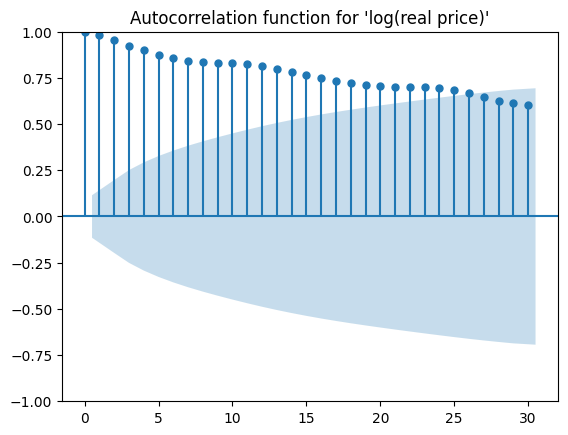

In [79]:
plot_acf(filtered_gasoline['Log_Real_Price'], 
         lags=30, 
         title="Autocorrelation function for 'log(real price)'");

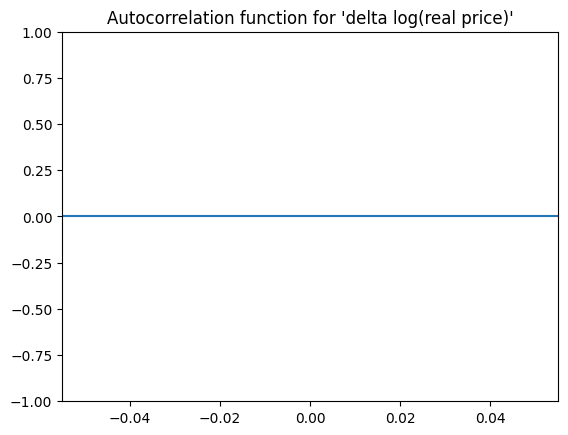

In [80]:
plot_acf(filtered_gasoline['Delta_Log'], 
         lags=30, 
         title="Autocorrelation function for 'delta log(real price)'");